In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

import os
import urllib
import re
import random
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import pickle
from torch.nn import functional as F

from collections import OrderedDict, Counter

In [5]:
#!pip install sacrebleu
!pip show sacrebleu

Name: sacrebleu
Version: 1.5.1
Summary: Hassle-free computation of shareable, comparable, and reproducible BLEU, chrF, and TER scores
Home-page: https://github.com/mjpost/sacrebleu
Author: Matt Post
Author-email: post@cs.jhu.edu
License: Apache License 2.0
Location: /home/guntis/anaconda3/envs/tw131/lib/python3.8/site-packages
Requires: portalocker
Required-by: 


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


#Text preprocessing

In [4]:
#!pip install subword-nmt
!pip show subword-nmt

Name: subword-nmt
Version: 0.3.7
Summary: Unsupervised Word Segmentation for Neural Machine Translation and Text Generation
Home-page: https://github.com/rsennrich/subword-nmt
Author: Rico Sennrich
Author-email: None
License: MIT
Location: /home/guntis/anaconda3/envs/tw131/lib/python3.8/site-packages
Requires: 
Required-by: 


In [6]:
# Read Hemingway texts from URL. There are Hemingway's "A Farewell to arms"
text_input = urllib.request.urlopen('http://www.ltn.lv/~guntis/translation_dataset/dataset_en_small.txt').read().decode("utf-8", "ignore")
text_output = urllib.request.urlopen('http://www.ltn.lv/~guntis/translation_dataset/dataset_lv_small.txt').read().decode("utf-8-sig", "ignore")

with open('hemingway.en.txt', 'w') as f:
    f.write(text_input)

with open('hemingway.lv.txt', 'w') as f:
    f.write(text_output)

In [8]:
!git clone https://github.com/moses-smt/mosesdecoder.git

Cloning into 'mosesdecoder'...
remote: Enumerating objects: 148070, done.
remote: Counting objects: 100% (498/498), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 148070 (delta 315), reused 433 (delta 289), pack-reused 147572
Receiving objects: 100% (148070/148070), 129.86 MiB | 21.70 MiB/s, done.
Resolving deltas: 100% (114341/114341), done.


In [12]:
# Normalize and tokenize texts

!cat hemingway.en.txt | mosesdecoder/scripts/tokenizer/normalize-punctuation.perl -l en \
  | mosesdecoder/scripts/tokenizer/tokenizer.perl -a -l en > hemingway.en.tok.txt

!cat hemingway.lv.txt | mosesdecoder/scripts/tokenizer/normalize-punctuation.perl -l lv \
  | mosesdecoder/scripts/tokenizer/tokenizer.perl -a -l lv > hemingway.lv.tok.txt

Tokenizer Version 1.1
Language: en
Number of threads: 1
Tokenizer Version 1.1
Language: lv
Number of threads: 1


In [11]:
# # Normalize and tokenize texts

# #!cat hemingway.en.txt | mosesdecoder/scripts/tokenizer/normalize-punctuation.perl -l en \
# !cat hemingway.en.txt \
#   | mosesdecoder/scripts/tokenizer/tokenizer.perl -a -l en > hemingway.en.tok.txt

# # !cat hemingway.lv.txt | mosesdecoder/scripts/tokenizer/normalize-punctuation.perl -l lv \
# !cat hemingway.lv.txt \
#   | mosesdecoder/scripts/tokenizer/tokenizer.perl -a -l lv > hemingway.lv.tok.txt

Tokenizer Version 1.1
Language: en
Number of threads: 1
Tokenizer Version 1.1
Language: lv
Number of threads: 1


In [15]:
!mosesdecoder/scripts/recaser/train-truecaser.perl -corpus hemingway.en.tok.txt -model tc.en
!mosesdecoder/scripts/recaser/train-truecaser.perl -corpus hemingway.lv.tok.txt -model tc.lv

!mosesdecoder/scripts/recaser/truecase.perl -model tc.en < hemingway.en.tok.txt > hemingway.en.tc.txt
!mosesdecoder/scripts/recaser/truecase.perl -model tc.lv < hemingway.lv.tok.txt > hemingway.lv.tc.txt

In [61]:
num_bpe_merges = 10000
vocab_size = 5500
!echo BPE_ops=$num_bpe_merges vocab_size=$vocab_size

BPE_ops=10000 vocab_size=5500


In [62]:
# !subword-nmt learn-joint-bpe-and-vocab --input en.tc.txt lv.tc.txt -s 10000 -o tokens.txt --write-vocabulary token_freq.en.txt token_freq.lv.txt
!subword-nmt learn-joint-bpe-and-vocab --input hemingway.en.tc.txt -s $num_bpe_merges -o tokens.en.txt --write-vocabulary token_freq.en.txt
!subword-nmt learn-joint-bpe-and-vocab --input hemingway.lv.tc.txt -s $num_bpe_merges -o tokens.lv.txt --write-vocabulary token_freq.lv.txt

no pair has frequency >= 2. Stopping
no pair has frequency >= 2. Stopping


In [63]:
def build_vocab(freq_file, vocab_size):
    vocab = ['<eos>', '<unk>', '<pad>']
    with open(freq_file, 'r') as f:
        for line in f.readlines():
            token, _ = line.split()
            vocab.append(token)

    return vocab[:vocab_size]

en_vocab = build_vocab('token_freq.en.txt', vocab_size)
lv_vocab = build_vocab('token_freq.lv.txt', vocab_size)

with open('vocab.en.txt', 'w') as f:
    for i, token in enumerate(en_vocab):
        f.write(f"{token} {i + 1} \n")

with open('vocab.lv.txt', 'w') as f:
    for i, token in enumerate(lv_vocab):
        f.write(f"{token} {i + 1} \n")

In [64]:
!subword-nmt apply-bpe -c tokens.en.txt --vocabulary vocab.en.txt --vocabulary-threshold 1 < hemingway.en.tc.txt > hemingway.en.BPE.txt
!subword-nmt apply-bpe -c tokens.lv.txt --vocabulary vocab.lv.txt --vocabulary-threshold 1 < hemingway.lv.tc.txt > hemingway.lv.BPE.txt

In [65]:
with open('hemingway.lv.BPE.txt', 'r') as f:
    text_input = f.read()

with open('hemingway.en.BPE.txt', 'r') as f:
    text_output = f.read()

#MinGPT

In [66]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

def calculate_attention_token(attention, top_k, model):
    logits = model.head(attention)
    logits = logits[:, -1, :]
    logits = top_k_logits(logits, top_k)

    probs = F.softmax(logits)

    _, ix = torch.topk(probs, k=1, dim=-1)
    ix = torch.multinomial(probs, num_samples=top_k)

    return ix[0]


@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None, output_attention=False):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    attention_state = [[] for _ in model.blocks]

    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)

        if output_attention:
            b, t = x.size()

            for block_id in range(len(model.blocks)):
                att = model.blocks[block_id].attn.att
                attention_state[block_id].append(att)

        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    if output_attention:
        return x, attention_state

    return x


In [67]:
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.att = None

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))

        self.att = att

        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        b, t = idx.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(idx) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [68]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import sacrebleu
import math
import logging
from random import choice

from tqdm import tqdm
import numpy as np

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader

logger = logging.getLogger(__name__)

def clean_tokens(sentence):
    return sentence.replace('@@ ', '').replace(' @', '').replace('@ ', '')

class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 64
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, valid_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.valid_dataset = valid_dataset
        self.config = config

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info("saving %s", self.config.ckpt_path)
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset
            if split == 'test':
                data = self.test_dataset
            elif split == 'valid':
                data = self.valid_dataset
                model.eval()
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=config.batch_size,
                                num_workers=config.num_workers)

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            logits_total = None
            x_total = None
            y_total = None
            for it, (x, y) in pbar:

                # place data on the correct device
                x = x.to(self.device)
                y = y.to(self.device)

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model(x, y)
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())
                    if split == 'valid':
                        if logits_total is None:
                            logits_total = logits
                            x_total = x
                            y_total = y
                        else:
                            logits_total = torch.cat((logits_total, logits), dim=0)
                            x_total = torch.cat((x_total, x), dim=0)
                            y_total = torch.cat((y_total, y), dim=0)
                        

                if is_train:
                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. mean loss: {float(np.mean(losses)):.5f}. lr {lr:e}")

            if split == 'test':
                test_loss = float(np.mean(losses))
                print(f"test loss: {test_loss}")
                return test_loss

            if split == 'valid':
                test_loss = float(np.mean(losses))
                print(f"valid loss: {test_loss}")

                eval_results = []
                translation_results = []
                context_list = []

                for idx in range(len(logits_total)):
                    intent = (x_total[idx] == valid_dataset.tokenizer_input.encode(['<eos>'])[0]).nonzero(as_tuple=True)[0][0]

                    probs = F.softmax(logits_total[idx], dim=-1)
                    # sample from the distribution or take the most likely
                    _, predicted = torch.topk(probs, k=1, dim=-1)
                    context = clean_tokens(data.tokenizer_input.decode(x_total[idx][:intent - 1], True))
                    completion = clean_tokens(data.tokenizer_output.decode(predicted[intent:], True))
                    real = clean_tokens(data.tokenizer_output.decode(y_total[idx][intent:], True))

                    context_list.append(context)
                    translation_results.append(completion)
                    eval_results.append(real)
                
                with open('valid.txt', 'w') as f:
                    f.write("\n".join(translation_results))

                with open('eval.txt', 'w') as f:
                    f.write("\n".join(eval_results))

                with open('context.txt', 'w') as f:
                    f.write("\n".join(context_list))


                !cat valid.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > valid.detok.txt
                !cat eval.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > eval.detok.txt
                !cat context.txt | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > context.detok.txt

                with open('eval.detok.txt', 'r') as f:
                    eval_results = [l.strip() for l in f.readlines()]
                with open('valid.detok.txt', 'r') as f:
                    translation_results = [l.strip() for l in f.readlines()]
                with open('context.detok.txt', 'r') as f:
                    context_list = [l.strip() for l in f.readlines()]

                idx = choice(range(len(context_list)))
                
                print(f'Input:            {context_list[idx]}')
                print(f'Predicted output: {translation_results[idx]}')
                print(f'Real output:      {eval_results[idx]}')

                refs = [eval_results]
                sys = translation_results
                bleu = sacrebleu.corpus_bleu(sys, refs)
                print(f'BLEU: {bleu.score}')
                print('--------------------------------------------------')

                return test_loss, bleu.score

        test_loss_list = []
        valid_loss_list = []
        valid_bleu_list = []
        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')
                test_loss_list.append(test_loss)

            if self.valid_dataset is not None:
                valid_loss, bleu_score = run_epoch('valid')
                valid_loss_list.append(valid_loss)
                valid_bleu_list.append(bleu_score)

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()

        return test_loss_list, valid_loss_list, valid_bleu_list


#Training

In [69]:

class Tokenizer:
    def __init__(self, data, vocab_size, vocab):
        self.vocab_size = vocab_size
        self.vocab = vocab

        self.stoi = {ch: i for i, ch in enumerate(self.vocab)}
        self.itos = {i: ch for i, ch in enumerate(self.vocab)}
    
    def tokenize(self, data, block_size):
        tokenized_text = data.split()
        # Filter empty strings
        tokenized_text = [x for x in tokenized_text if x]
        result = []
        for tokenized in tokenized_text:
            # In case other single # found, replace them with <unk> special token, marking the element as unknown
            if tokenized in self.vocab:
                result.append(tokenized)
            else:
                result.append('<unk>')

        # in case the sentence is longer, than block_size, we trim the sentence
        return result[:block_size]
    
    def encode(self, data):
        return [self.stoi[s] for s in data]
    
    def decode(self, data, clean_paddings=False):
        text = ' '.join([self.itos[int(i)] for i in data])

        if not clean_paddings:
            return text
        return text.replace('<pad>', '').replace('  ', '')

In [70]:
# vocab_size = 10000

# vocab_input = None
# if os.path.exists('vocab_input.pkl'):
#     with open('vocab_input.pkl', 'rb') as f:
#         vocab_input = pickle.load(f)
        
# vocab_output = None
# if os.path.exists('vocab_output.pkl'):
#     with open('vocab_output.pkl', 'rb') as f:
#         vocab_output = pickle.load(f)

# building vocabluary can take some time. ~5 minutes for 10_000 tokens for each tokenizer. 
tokenizer_input = Tokenizer(text_input, vocab_size, lv_vocab)
tokenizer_output = Tokenizer(text_output, vocab_size, en_vocab)

In [71]:
# with open('vocab_input.pkl', 'wb') as f:
#     pickle.dump(tokenizer_input.vocab, f)

# with open('vocab_output.pkl', 'wb') as f:
#     pickle.dump(tokenizer_output.vocab, f)

In [72]:
# Shuffle texts by lines
texts = list(zip(text_output.splitlines(), text_input.splitlines()))
random.shuffle(texts)

text_output, text_input = zip(*texts)

In [73]:
# Split texts into train, test and validation datasets
train_dataset_size = round(0.85 * len(text_output))
test_dataset_size = round(0.1 * len(text_output))
valid_dataset_size = round(0.05 * len(text_output))

train_input = text_input[:train_dataset_size]
test_input = text_input[train_dataset_size:train_dataset_size + test_dataset_size]
valid_input = text_input[-valid_dataset_size:]

train_output = text_output[:train_dataset_size]
test_output = text_output[train_dataset_size:train_dataset_size + test_dataset_size]
valid_output = text_output[-valid_dataset_size:]


In [74]:
from torch.utils.data import Dataset

class WordDataset(Dataset):

    def __init__(self, output_text, input_text, tokenizer_output, tokenizer_input, block_size):
        self.tokenizer_output = tokenizer_output
        self.tokenizer_input = tokenizer_input

        self.block_size = block_size * 2 + 1
        self.output_text = [tokenizer_output.tokenize(t, block_size) for t in output_text]
        self.input_text = [tokenizer_input.tokenize(t, block_size) for t in input_text]

    def __len__(self):
        return len(self.output_text)

    def __getitem__(self, idx):
        """
        The idea is to get the input sentence
        and translate it to output sentence (sentences could be on any language).

        In the init method we already split a sentence into tokens and filled with spaces,
        to have an equal sentence size. In this method we just encode the tokens to
        ids (a list of numbers), and we're trying to map ids sequences
        """

        tokenized_input_text = self.tokenizer_input.encode(self.input_text[idx])
        tokenized_output_text = self.tokenizer_output.encode(self.output_text[idx])

        dix = tokenized_input_text + self.tokenizer_output.encode(['<eos>']) + tokenized_output_text
        if len(dix) < self.block_size:
            dix += self.tokenizer_output.encode(['<pad>']) * (self.block_size - len(dix))

        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        y[:len(tokenized_input_text) - 1] = -100

        return x, y

In [75]:
block_size = 100  # the estimate how long lines the text could be (token count)

train_dataset = WordDataset(train_output, train_input, tokenizer_output, tokenizer_input, block_size)
test_dataset = WordDataset(test_output, test_input, tokenizer_output, tokenizer_input, block_size)
valid_dataset = WordDataset(valid_output, valid_input, tokenizer_output, tokenizer_input, block_size)

In [76]:
number_of_heads = 8
number_of_layers = 6

# from mingpt.model import GPT, GPTConfig
mconf = GPTConfig(tokenizer_output.vocab_size, train_dataset.block_size,
                  n_layer=number_of_layers, n_head=number_of_heads, n_embd=512)
model = GPT(mconf)

In [77]:
# from mingpt.trainer import Trainer, TrainerConfig

tokens_per_epoch = len(train_dataset) * block_size
train_epochs = 100

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=128, learning_rate=3e-4,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='minGPT-LV-EN-translator_model.pt',
                      num_workers=1, weight_decay=0.0001, betas=(0.9, 0.98))
trainer = Trainer(model, train_dataset, test_dataset, valid_dataset, tconf)

In [78]:
param_count = sum([param.nelement() for param in model.parameters()])

print(f'Parameters count: {param_count}')

Parameters count: 24650240


In [79]:
test_loss_list, valid_loss_list, valid_bleu_list = trainer.train()

epoch 1 iter 58: train loss 0.30184. mean loss: 0.72940. lr 2.999393e-04: 100%|██████████| 59/59 [00:23<00:00,  2.52it/s]


test loss: 0.3149911505835397
valid loss: 0.35734643787145615
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nevaru iedomāties, ka man tā būtu jāguļ
Predicted output: "I.......
Real output:      "I can 't imagine lying like that.
BLEU: 0.23039652353995288
--------------------------------------------------


epoch 2 iter 58: train loss 0.24942. mean loss: 0.30499. lr 2.994109e-04: 100%|██████████| 59/59 [00:23<00:00,  2.50it/s]


test loss: 0.27204665541648865
valid loss: 0.3055238425731659
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            upes dibenu klāja oļi un akmeņi, saulē nožuvuši balti, un caurtecēs ūdens bija dzidrs un straujš, un zils
Predicted output: the the road and the road and was and and the road and and the and the and the road the the the road. a. the.. the. the road.
Real output:      in the bed of the river there were pebbles and boulders, dry and white in the sun, and the water was clear and swiftly moving and blue in the channels.
BLEU: 3.4103353151194153
--------------------------------------------------


epoch 3 iter 58: train loss 0.23493. mean loss: 0.26739. lr 2.983413e-04: 100%|██████████| 59/59 [00:23<00:00,  2.47it/s]


test loss: 0.2537184549229486
valid loss: 0.28326554596424103
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "vai neiedzersim?
Predicted output: "you you don be you little?"
Real output:      "perhaps we should have a drink."
BLEU: 4.404315840837544
--------------------------------------------------


epoch 4 iter 58: train loss 0.25479. mean loss: 0.24561. lr 2.967344e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.24290485680103302
valid loss: 0.27639190107584
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            kur mūs neviens nepazītu "
Predicted output: they to 're 't be.. "
Real output:      anywhere we don 't know people. "
BLEU: 5.460638667813124
--------------------------------------------------


epoch 5 iter 58: train loss 0.17206. mean loss: 0.22636. lr 2.945960e-04: 100%|██████████| 59/59 [00:24<00:00,  2.46it/s]


test loss: 0.23375763424805232
valid loss: 0.2700066566467285
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            iemesls meklējams daudz dziļāk
Predicted output: I was a-be. a.
Real output:      there was more to it than that.
BLEU: 7.147224700052678
--------------------------------------------------


epoch 6 iter 58: train loss 0.23088. mean loss: 0.21062. lr 2.919339e-04: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


test loss: 0.22963869358812058
valid loss: 0.26865021884441376
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            XXXV
Predicted output: CHAPTER XXXX@@
Real output:      CHAPTER XXXV
BLEU: 8.014791348420054
--------------------------------------------------


epoch 7 iter 58: train loss 0.18829. mean loss: 0.19442. lr 2.887576e-04: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]


test loss: 0.22720458039215632
valid loss: 0.2609049528837204
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "tagad, ja tu neesi man līdzās, jūtu tukšumu"
Predicted output: "I I you don 't be me, 'm 't be fine, the man you"
Real output:      "now if you aren 't with me I haven 't a thing in the world."
BLEU: 8.025240984308844
--------------------------------------------------


epoch 8 iter 58: train loss 0.20827. mean loss: 0.17982. lr 2.850787e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.22690108844212123
valid loss: 0.2660006210207939
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            krāsnī jau sprēgāja uguns, un celties vēl negribējās, un mēs vērojām sniegputeni
Predicted output: we went down the and the road and yand the road and we the car and up
Real output:      we stayed in bed with the fire roaring in the stove and watched the snow fall.
BLEU: 9.413163720469498
--------------------------------------------------


epoch 9 iter 58: train loss 0.14551. mean loss: 0.16438. lr 2.809105e-04: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


test loss: 0.22616978415421077
valid loss: 0.25721387192606926
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            kad vairs negāju uz kruķiem, mēs nevarējām staigāt kopā, jo ir nepiedienīgi māsai staigāt divatā ar slimnieku, kurš neizskatās pēc tāda, kam vajadzīgs pavadonis; tāpēc pēcpusdienās mēs bijām kopā
Predicted output: when did not come the when on to for we could not the we we would going ina with a little of be with the inGabriele ininwe a little. we not come at we we could for. l. and you could going come. with the river.
Real output:      they would not let us go out together when I was off crutches because it was unseemly for a nurse to be seen unchaperoned with a patient who did not look as though he needed attendance, so we were not together much in the afternoons.
BLEU: 10.04336032292374
--------------------------------------------------


epoch 10 iter 58: train loss 0.12635. mean loss: 0.14926. lr 2.762681e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.2287924247128623
valid loss: 0.2669055126607418
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            Pārbaucām pāri upei, un es redzēju, ka ūdens bija stipri cēlies
Predicted output: there could the trees, I saw the the was gone over country
Real output:      we crossed the river and I saw that it was running high.
BLEU: 10.373088588237126
--------------------------------------------------


epoch 11 iter 58: train loss 0.10082. mean loss: 0.13527. lr 2.711683e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.23083416053227016
valid loss: 0.26096566766500473
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "man šķiet, viņš ir miris", es atbildēju
Predicted output: "I 's all, 'm." I said.
Real output:      "he 's dead I think," I said.
BLEU: 10.455720686460992
--------------------------------------------------


epoch 12 iter 58: train loss 0.15030. mean loss: 0.12179. lr 2.656296e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.23501879402569362
valid loss: 0.2747500166296959
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "man jāiet"
Predicted output: "I have to go."
Real output:      "I have to go."
BLEU: 11.046511700730115
--------------------------------------------------


epoch 13 iter 58: train loss 0.11091. mean loss: 0.10799. lr 2.596721e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.24032043559210642
valid loss: 0.289326798170805
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "Vokere?
Predicted output: "where?"
Real output:      "walker?"
BLEU: 11.465390226803855
--------------------------------------------------


epoch 14 iter 58: train loss 0.09676. mean loss: 0.09615. lr 2.533173e-04: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.2445008967603956
valid loss: 0.2894304543733597
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            viņi jau bija aizvilkuši mani ceļa malā
Predicted output: they had me to me road of. road..
Real output:      they had me at the side of the road now.
BLEU: 11.71953660701414
--------------------------------------------------


epoch 15 iter 58: train loss 0.07340. mean loss: 0.08396. lr 2.465883e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.2471235373190471
valid loss: 0.2931816875934601
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "gan pastāstīšu, ja kādreiz spēšu to visu aptvert"
Predicted output: "think you if it out I can all it all. the time."
Real output:      'Til tell you about it if I ever get it straight in my head. "
BLEU: 11.162792436952488
--------------------------------------------------


epoch 16 iter 58: train loss 0.07375. mean loss: 0.07303. lr 2.395094e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.25395666488579344
valid loss: 0.3008826896548271
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            otras tādas nav "
Predicted output: they are thought. bad. it. "
Real output:      you never saw a town like that. "
BLEU: 11.818511333538051
--------------------------------------------------


epoch 17 iter 58: train loss 0.05511. mean loss: 0.06368. lr 2.321062e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.25722826378686087
valid loss: 0.28753380849957466
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "tu taču man neaizliegsi?
Predicted output: "you won 't go it like go go darling??"
Real output:      "you won 't say I can 't, will you?"
BLEU: 12.136221232044631
--------------------------------------------------


epoch 18 iter 58: train loss 0.07081. mean loss: 0.05464. lr 2.244057e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.26155525020190645
valid loss: 0.3080053851008415
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "kāpēc?
Predicted output: "why not?"
Real output:      "why not?"
BLEU: 11.61481007563696
--------------------------------------------------


epoch 19 iter 58: train loss 0.04246. mean loss: 0.04660. lr 2.164356e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.2667830692870276
valid loss: 0.3142243027687073
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "ļoti"
Predicted output: "very much."
Real output:      "very much."
BLEU: 12.422963022264506
--------------------------------------------------


epoch 20 iter 58: train loss 0.03464. mean loss: 0.03990. lr 2.082249e-04: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


test loss: 0.274089229958398
valid loss: 0.314512699842453
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tas bija garš, parasts dzelzceļa tilts pāri gandrīz izsusējušai upes gultnei
Predicted output: the was a bridge high bridge bridge over the was low muddy river bridge. bridge with
Real output:      it was a long plain iron bridge across what was usually a dry river-bed.
BLEU: 12.143101782850406
--------------------------------------------------


epoch 21 iter 58: train loss 0.03793. mean loss: 0.03380. lr 1.998033e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.2783955122743334
valid loss: 0.3160559609532356
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "vai tu, Barto, nevari pameklēt tomātu mērci?
Predicted output: "will 't you go the ddyou,"? "
Real output:      "couldn 't you find tomato sauce, Barto?"
BLEU: 11.741626302455982
--------------------------------------------------


epoch 22 iter 58: train loss 0.02392. mean loss: 0.02920. lr 1.912013e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.28067008938108173
valid loss: 0.32692087441682816
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "viens divi" kuņģis beigts, un rokas sāk trīcēt
Predicted output: "in talking ve and drink, one you lie-os'"
Real output:      "it ruins the stomach and makes the hand shake.
BLEU: 11.986232342234029
--------------------------------------------------


epoch 23 iter 58: train loss 0.02439. mean loss: 0.02484. lr 1.824500e-04: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]


test loss: 0.2844448813370296
valid loss: 0.32922423630952835
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē, signorino
Predicted output: "no, signorino.
Real output:      "no, signorino.
BLEU: 11.896803446746043
--------------------------------------------------


epoch 24 iter 58: train loss 0.01876. mean loss: 0.02127. lr 1.735812e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.2866666870457785
valid loss: 0.3451358675956726
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            iemesls meklējams daudz dziļāk
Predicted output: besides were a of be, a pu@@
Real output:      there was more to it than that.
BLEU: 12.23126140872842
--------------------------------------------------


epoch 25 iter 58: train loss 0.01861. mean loss: 0.01845. lr 1.646270e-04: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.2916233113833836
valid loss: 0.33983520418405533
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            viņš paskatījās uz mani, iegāja mājā un iznāca bez pulksteņa
Predicted output: he looked at me in looking into the farmhouse and saw out across hat farmhouse over
Real output:      he looked at me, went in the house and came back without the clock.
BLEU: 12.477719981332411
--------------------------------------------------


epoch 26 iter 58: train loss 0.01991. mean loss: 0.01592. lr 1.556198e-04: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


test loss: 0.2906916780131204
valid loss: 0.3382393792271614
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "jūs noteikti nožēlosiet, ka aizbraucāt no Lokarno", otrs ierēdnis noteica
Predicted output: "you 'll you you ought get you you you," the first way said.
Real output:      "I believe that you will regret leaving Locarno," the second official said.
BLEU: 12.454071599584758
--------------------------------------------------


epoch 27 iter 58: train loss 0.01540. mean loss: 0.01401. lr 1.465923e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.2951467675822122
valid loss: 0.3428318277001381
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            āda bija tumša un gluda un spīdēja kā nodilušiem segliem
Predicted output: I legs was cool and cool se under though yed off.
Real output:      the leather was dark and oiled smooth as a used saddle.
BLEU: 12.038938763985424
--------------------------------------------------


epoch 28 iter 58: train loss 0.01208. mean loss: 0.01242. lr 1.375771e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.29856390186718534
valid loss: 0.3354783281683922
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es iznācu ārā pie ratiem un samaksāju ormanim, un mēs ar Ketrinu devāmies iekšā
Predicted output: I I paid home and the driver and then out driver, then paid said paid asked on bed.
Real output:      then I went out to the carriage, paid the driver, and Catherine and I walked in together.
BLEU: 12.390132797624394
--------------------------------------------------


epoch 29 iter 58: train loss 0.01317. mean loss: 0.01103. lr 1.286068e-04: 100%|██████████| 59/59 [00:25<00:00,  2.34it/s]


test loss: 0.3014840568814959
valid loss: 0.34842967987060547
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "es viņu ienesu", garais anglis teica itāliski
Predicted output: "I 'll Italian him in Italian" he English said.. Italian.
Real output:      "I have brought him in," the tall Englishman said in Italian.
BLEU: 12.278799332177343
--------------------------------------------------


epoch 30 iter 58: train loss 0.00966. mean loss: 0.00986. lr 1.197141e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.30299483452524456
valid loss: 0.3500536009669304
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            Krouvels aizgāja nopirkt biļetes, un mēs pa to laiku skatījāmies, kā žokeji vēlreiz izmeta apli zem kokiem un tad pa skrejceļu rikšoja uz pagriezienu "uz starta vietu
Predicted output: Crowell and out the walked a we on we found the town filled out the stone and then came in a the street in the lake. had inched ck. of the the street. it horses. filled take filled
Real output:      Crowell went over and bought the tickets while we watched the jockeys ride around once more and then go out under the trees to the track and gallop slowly up to the turn where the start was to be.
BLEU: 12.748963839868063
--------------------------------------------------


epoch 31 iter 58: train loss 0.00961. mean loss: 0.00869. lr 1.109311e-04: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


test loss: 0.3042469492980412
valid loss: 0.34974631667137146
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "es zinu
Predicted output: "I know it
Real output:      "I know.
BLEU: 12.381902715895444
--------------------------------------------------


epoch 32 iter 58: train loss 0.01252. mean loss: 0.00797. lr 1.022896e-04: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


test loss: 0.3102730597768511
valid loss: 0.3605722412467003
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            āda bija tumša un gluda un spīdēja kā nodilušiem segliem
Predicted output: they legs, cool and cool ly under though yed under.
Real output:      the leather was dark and oiled smooth as a used saddle.
BLEU: 12.490617765868494
--------------------------------------------------


epoch 33 iter 58: train loss 0.00639. mean loss: 0.00702. lr 9.382093e-05: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.31275440965379986
valid loss: 0.36863747984170914
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            XXI
Predicted output: CHAPTER XXI
Real output:      CHAPTER XXI
BLEU: 12.516917678498261
--------------------------------------------------


epoch 34 iter 58: train loss 0.00607. mean loss: 0.00650. lr 8.555575e-05: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.31336547221456257
valid loss: 0.3653646409511566
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tā bija mis Fērgusone
Predicted output: Miss was Miss Ferguson.
Real output:      it was Miss Ferguson.
BLEU: 12.420487182572431
--------------------------------------------------


epoch 35 iter 58: train loss 0.00541. mean loss: 0.00580. lr 7.752400e-05: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.3149009644985199
valid loss: 0.36483749002218246
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "Neej", es teicu
Predicted output: "don 't,," I said.
Real output:      "don 't go," I said.
BLEU: 12.883255954232322
--------------------------------------------------


epoch 36 iter 58: train loss 0.00491. mean loss: 0.00521. lr 6.975478e-05: 100%|██████████| 59/59 [00:24<00:00,  2.36it/s]


test loss: 0.3173705850328718
valid loss: 0.39277658611536026
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tā nav tikai tukša komēdija "
Predicted output: it was not if little hurry if "
Real output:      it is not a dirty joke. "
BLEU: 12.634442699315253
--------------------------------------------------


epoch 37 iter 58: train loss 0.00388. mean loss: 0.00473. lr 6.227623e-05: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.31824112789971487
valid loss: 0.35955560952425003
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            gribu, lai tev būtu laimīga dzīve
Predicted output: I want you to have a life life.
Real output:      I want you to have a fine life.
BLEU: 12.72289176422439
--------------------------------------------------


epoch 38 iter 58: train loss 0.00357. mean loss: 0.00430. lr 5.511544e-05: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


test loss: 0.3202820675713675
valid loss: 0.3781061992049217
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē", mācītājs sacīja
Predicted output: "no," said the priest.
Real output:      "no," said the priest.
BLEU: 12.449218176368579
--------------------------------------------------


epoch 39 iter 58: train loss 0.00385. mean loss: 0.00405. lr 4.829835e-05: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.3210890591144562
valid loss: 0.3783748000860214
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "mēs paliksim, kamēr paēdīsim pusdienas", Ketrina sacīja
Predicted output: "we 'll have here we our," Catherine said.
Real output:      "we 'll stay till after dinner," Catherine said.
BLEU: 12.742104311233936
--------------------------------------------------


epoch 40 iter 58: train loss 0.00573. mean loss: 0.00371. lr 4.184965e-05: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.32268169948032926
valid loss: 0.3727636858820915
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            pa abām viņas saklāja gultu un mani nemaz necēla ārā
Predicted output: then of did me bed from me and the between
Real output:      together they made the bed with me in it.
BLEU: 12.867919933545334
--------------------------------------------------


epoch 41 iter 58: train loss 0.00389. mean loss: 0.00339. lr 3.579270e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.32427997248513357
valid loss: 0.3830628916621208
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "vai jums patīk Itālija?
Predicted output: "do like??"
Real output:      "you love Italy?"
BLEU: 12.734260160996447
--------------------------------------------------


epoch 42 iter 58: train loss 0.00359. mean loss: 0.00321. lr 3.014944e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.32374324968882967
valid loss: 0.3854171633720398
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "Spekulanti iztirgo"
Predicted output: "Abwhole ws p-away li, out.."
Real output:      "the dogfish are selling it somewhere else."
BLEU: 12.53965454069016
--------------------------------------------------


epoch 43 iter 58: train loss 0.00389. mean loss: 0.00314. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.3238311197076525
valid loss: 0.3782701790332794
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es teicu
Predicted output: "get ho,," I said to
Real output:      "ho ho ho," I said.
BLEU: 12.60282382514838
--------------------------------------------------


epoch 44 iter 58: train loss 0.00172. mean loss: 0.00292. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.3237475667681013
valid loss: 0.3740032836794853
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "tas aiz nevaļas"
Predicted output: "it isn stopped just hard."
Real output:      "we 've been very busy."
BLEU: 12.78271663974143
--------------------------------------------------


epoch 45 iter 58: train loss 0.00345. mean loss: 0.00279. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.3239204117230007
valid loss: 0.36598773300647736
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            diez vai viņi ticēja jel vienam manam vārdam; nodomāju, cik tas viss muļķīgi, tikpat kā tiesā
Predicted output: I thought not see out had off of joke of God bandages of I was I was better. that was better me joke. book.
Real output:      I do not think they believed a word of the story and I thought it was silly but it was like a law-court.
BLEU: 12.580734010286683
--------------------------------------------------


epoch 46 iter 58: train loss 0.00227. mean loss: 0.00277. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.3258011298520224
valid loss: 0.38543207198381424
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "Ticiāns", Ketrina teica
Predicted output: "you-" Catherine said.
Real output:      "Titian," Catherine said.
BLEU: 12.324945480121613
--------------------------------------------------


epoch 47 iter 58: train loss 0.00264. mean loss: 0.00267. lr 3.000000e-05: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]


test loss: 0.327461234160832
valid loss: 0.3738481402397156
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            mazā istaba ar krāsni kaktā bija mūsu dzīvojamā istaba
Predicted output: the snow room was the room, wet room rious ce room.
Real output:      the small room with the stove was our livingroom.
BLEU: 12.754959031943978
--------------------------------------------------


epoch 48 iter 58: train loss 0.00373. mean loss: 0.00258. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.32687263403620037
valid loss: 0.3718154579401016
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tur ir karsts un pilns ar blusām
Predicted output: it is a in a place the ayoung
Real output:      it is hot and full of fleas.
BLEU: 12.943079994690418
--------------------------------------------------


epoch 49 iter 58: train loss 0.00292. mean loss: 0.00260. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


test loss: 0.32840608273233685
valid loss: 0.3885938450694084
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            kā parasti notiek
Predicted output: but they gave 't much. the...
Real output:      but I wasn 't crazy in any complicated manner.
BLEU: 12.617394124029925
--------------------------------------------------


epoch 50 iter 58: train loss 0.00236. mean loss: 0.00255. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.3279318852084024
valid loss: 0.3806307688355446
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "kāds tu esi auša"
Predicted output: "you 're a a lovely.."
Real output:      "you 're such a silly boy."
BLEU: 12.742190624795796
--------------------------------------------------


epoch 51 iter 58: train loss 0.00215. mean loss: 0.00244. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.3293650320598057
valid loss: 0.3944753259420395
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            uguns un dūmi, bet iekšā tukšpadsmit
Predicted output: the stopped in soon of they. of
Real output:      all fire and smoke and nothing inside.
BLEU: 12.770160427109852
--------------------------------------------------


epoch 52 iter 58: train loss 0.00299. mean loss: 0.00240. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.3297968677112034
valid loss: 0.3887185752391815
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            pēdējā brīdī ", Meijers teica," uz to lika prāvu summu "
Predicted output: sometimes the beard,, "he,," please throw his basin, San. it.
Real output:      at the last minute, "Meyers said," they put a lot of money on him. "
BLEU: 12.59563860312388
--------------------------------------------------


epoch 53 iter 58: train loss 0.00318. mean loss: 0.00235. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.3311917611530849
valid loss: 0.38581930845975876
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            pēdējā brīdī ", Meijers teica," uz to lika prāvu summu "
Predicted output: sometimes the beard,, "he,," he throw his basin, San. it.
Real output:      at the last minute, "Meyers said," they put a lot of money on him. "
BLEU: 12.50848704775727
--------------------------------------------------


epoch 54 iter 58: train loss 0.00270. mean loss: 0.00224. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.33083535943712505
valid loss: 0.4093533679842949
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "tagad, ja tu neesi man līdzās, jūtu tukšumu"
Predicted output: "now, you 're 't got me, am 't washed fine. my glass you"
Real output:      "now if you aren 't with me I haven 't a thing in the world."
BLEU: 12.361247375503536
--------------------------------------------------


epoch 55 iter 58: train loss 0.00227. mean loss: 0.00222. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.33063930698803495
valid loss: 0.37414104491472244
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            mēs metāmies lejā no uzbēruma
Predicted output: we started off the the embankment.
Real output:      we dropped down beside the embankment.
BLEU: 12.592617680036541
--------------------------------------------------


epoch 56 iter 58: train loss 0.00267. mean loss: 0.00216. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3332676887512207
valid loss: 0.3956875205039978
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tagad vātis bija apdzijušas un ceļi sapampuši un mainījuši krāsu, un ikri iekrituši, taču sastrutojuma nebija
Predicted output: the and had cold arms and green roads, under and barsed and under white and. and it were under guns iles.
Real output:      now they were crusted and the knee was swollen and discolored and the calf sunken but there was no pus.
BLEU: 12.590959989528304
--------------------------------------------------


epoch 57 iter 58: train loss 0.00247. mean loss: 0.00214. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.3330829313823155
valid loss: 0.3945225030183792
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "Nenokļuvāt īstajā vietā
Predicted output: "it was too place to to.
Real output:      "that 's no place for that.
BLEU: 12.3515399791036
--------------------------------------------------


epoch 58 iter 58: train loss 0.00240. mean loss: 0.00209. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.42it/s]


test loss: 0.3340979516506195
valid loss: 0.39380595833063126
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            viņš paskatījās uz mani, iegāja mājā un iznāca bez pulksteņa
Predicted output: he looked out me and his out the farmhouse and saw out across a field down
Real output:      he looked at me, went in the house and came back without the clock.
BLEU: 12.68364193031721
--------------------------------------------------


epoch 59 iter 58: train loss 0.00228. mean loss: 0.00213. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


test loss: 0.3340273414339338
valid loss: 0.3977029323577881
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "un tomēr es dziedāšu" Skalā "", Simonss noteica
Predicted output: "I 'll sing / / Ospedale in" Piani said.
Real output:      "I 'll sing at the Scala," Simmons said.
BLEU: 12.277947395362288
--------------------------------------------------


epoch 60 iter 58: train loss 0.00194. mean loss: 0.00203. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.3349415063858032
valid loss: 0.39491717517375946
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "maita tāds", viņš noteica
Predicted output: "he little of dead bitch," he said.
Real output:      "the son of a bitch," he said.
BLEU: 12.579838711828392
--------------------------------------------------


epoch 61 iter 58: train loss 0.00248. mean loss: 0.00196. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.33463033182280405
valid loss: 0.3830427899956703
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
BLEU: 12.452204059411487
--------------------------------------------------


epoch 62 iter 58: train loss 0.00178. mean loss: 0.00195. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.3345004064696176
valid loss: 0.39055415987968445
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es esmu ateists "
Predicted output: I 've operating architeca. "
Real output:      I am an atheist. "
BLEU: 12.422341581667435
--------------------------------------------------


epoch 63 iter 58: train loss 0.00196. mean loss: 0.00193. lr 3.000000e-05: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.33600686277662006
valid loss: 0.3816431164741516
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "tā ir lietota", sieviete sacīja
Predicted output: "it 's a to" said woman said.
Real output:      "it is used," the woman said.
BLEU: 12.464671505862933
--------------------------------------------------


epoch 64 iter 58: train loss 0.00181. mean loss: 0.00192. lr 3.328093e-05: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.3352787750107901
valid loss: 0.40854740887880325
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            kamēr Ketrina sēdēja frizētavā, es aizgāju līdz alus pagrabiņam un iedzēru tumšo Minhenes alu un izlasīju laikrakstus
Predicted output: after I was go were sat in the the drink and and was them and entwrite and and they the cap I
Real output:      while Catherine was there I went up to a beer place and drank dark Munich beer and read the papers.
BLEU: 12.46977767078049
--------------------------------------------------


epoch 65 iter 58: train loss 0.00149. mean loss: 0.00194. lr 3.916018e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.33764263136046274
valid loss: 0.3996194154024124
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tur ir karsts un pilns ar blusām
Predicted output: it is a and a of the ayoung
Real output:      it is hot and full of fleas.
BLEU: 12.465939420959511
--------------------------------------------------


epoch 66 iter 58: train loss 0.00158. mean loss: 0.00198. lr 4.544093e-05: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.33957260847091675
valid loss: 0.4091126322746277
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "es jums pagādāšu
Predicted output: "I will. Him. drink.
Real output:      "I will get you a copy.
BLEU: 12.657985321939549
--------------------------------------------------


epoch 67 iter 58: train loss 0.00245. mean loss: 0.00209. lr 5.210041e-05: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.33833312562533785
valid loss: 0.3889131024479866
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "ja tikai nenošaus"
Predicted output: "if they won 't kill you."
Real output:      "if they don 't kill you."
BLEU: 12.330922359280883
--------------------------------------------------


epoch 68 iter 58: train loss 0.00288. mean loss: 0.00218. lr 5.911452e-05: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]


test loss: 0.33915782400539946
valid loss: 0.39567162841558456
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "labi
Predicted output: "all right.
Real output:      "all right.
BLEU: 12.379210403203743
--------------------------------------------------


epoch 69 iter 58: train loss 0.00298. mean loss: 0.00237. lr 6.645783e-05: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.33847502299717497
valid loss: 0.39050301909446716
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "negribas teikt"
Predicted output: "do don 't want a do you"
Real output:      "I don 't want to tell."
BLEU: 12.161180235176351
--------------------------------------------------


epoch 70 iter 58: train loss 0.00305. mean loss: 0.00244. lr 7.410376e-05: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3415168012891497
valid loss: 0.39805014431476593
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tagad vātis bija apdzijušas un ceļi sapampuši un mainījuši krāsu, un ikri iekrituši, taču sastrutojuma nebija
Predicted output: the and had cold arms and the roads, out and barsed and in white and. and those were out guns iles.
Real output:      now they were crusted and the knee was swollen and discolored and the calf sunken but there was no pus.
BLEU: 12.365756769926131
--------------------------------------------------


epoch 71 iter 58: train loss 0.00210. mean loss: 0.00263. lr 8.202461e-05: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.33990772707121714
valid loss: 0.3946336656808853
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            pati zinu
Predicted output: I know..
Real output:      I know it.
BLEU: 12.213161779685144
--------------------------------------------------


epoch 72 iter 58: train loss 0.00348. mean loss: 0.00277. lr 9.019168e-05: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.33965154205049786
valid loss: 0.4085669666528702
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tie veda gar upju grīvām uz jūru, un, lai tiktu uz priekšu šajā apvidū, jāiet pa takām līdzās attekām
Predicted output: they road were the in the road,, the foot, then the, roof, as p in in right in the house,
Real output:      the roads all go along the river mouths to the sea and to cross the country you must go along the paths beside the canals.
BLEU: 12.120300208189809
--------------------------------------------------


epoch 73 iter 58: train loss 0.00260. mean loss: 0.00304. lr 9.857539e-05: 100%|██████████| 59/59 [00:25<00:00,  2.35it/s]


test loss: 0.34177681377955843
valid loss: 0.4039185270667076
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
BLEU: 12.100236009575376
--------------------------------------------------


epoch 74 iter 58: train loss 0.00318. mean loss: 0.00319. lr 1.071454e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3428530735628946
valid loss: 0.3997672274708748
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "jā
Predicted output: "yes.
Real output:      "yes.
BLEU: 12.427264651730567
--------------------------------------------------


epoch 75 iter 58: train loss 0.00346. mean loss: 0.00340. lr 1.158706e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.34332302638462614
valid loss: 0.3948685824871063
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            pēc brīža piebrauca angļu sanitārā mašīna un mani ielika nestuvēs, un nestuves pacēla un iebīdīja mašīnā
Predicted output: after a while they stretcher and and into in the had him in the button on the the stretcher above in drink British. on was me got the
Real output:      after a while the English ambulance came up and they put me onto a stretcher and lifted the stretcher up to the ambulance level and shoved it in.
BLEU: 12.55333611280989
--------------------------------------------------


epoch 76 iter 58: train loss 0.00349. mean loss: 0.00372. lr 1.247194e-04: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.343518112386976
valid loss: 0.3960772603750229
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            mēs pārgājām pāri ielai un sākām iet pa otru pusi
Predicted output: we crossed the brickyard and went on the down. bank..
Real output:      we crossed the street and started to walk up the other side.
BLEU: 12.638125576186704
--------------------------------------------------


epoch 77 iter 58: train loss 0.00429. mean loss: 0.00394. lr 1.336599e-04: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.3399005319390978
valid loss: 0.39380279928445816
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            karš mūs sabrāļojis
Predicted output: the never never standing have
Real output:      we are war brothers.
BLEU: 12.49242669361241
--------------------------------------------------


epoch 78 iter 58: train loss 0.00531. mean loss: 0.00414. lr 1.426595e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.34137884633881704
valid loss: 0.4032581076025963
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            viņš ar īkšķi un rādītājpirkstu pieskārās zvaigznītēm pie apkakles
Predicted output: he pointed a thumb and the piece. rpiece and pools.
Real output:      he touched the stars at his collar with his thumb and forefinger.
BLEU: 12.321136749041825
--------------------------------------------------


epoch 79 iter 58: train loss 0.00584. mean loss: 0.00421. lr 1.516857e-04: 100%|██████████| 59/59 [00:24<00:00,  2.37it/s]


test loss: 0.3395905154091971
valid loss: 0.38998089730739594
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            un tad vēl jūsu skaistums "
Predicted output: another another you 've all. good. 'I said at..
Real output:      and then you are so very beautiful / 'I looked at her.
BLEU: 12.519558551154775
--------------------------------------------------


epoch 80 iter 58: train loss 0.00578. mean loss: 0.00490. lr 1.607058e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3423577036176409
valid loss: 0.389033779501915
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "es jums pagādāšu
Predicted output: "I will love a. drink of
Real output:      "I will get you a copy.
BLEU: 12.254634757603645
--------------------------------------------------


epoch 81 iter 58: train loss 0.00620. mean loss: 0.00493. lr 1.696871e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3424547484942845
valid loss: 0.39913704991340637
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "rīt"
Predicted output: "to-morrow."
Real output:      "to-morrow."
BLEU: 12.240170511721942
--------------------------------------------------


epoch 82 iter 58: train loss 0.00600. mean loss: 0.00517. lr 1.785971e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.3424304894038609
valid loss: 0.3941424712538719
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            viņš apsēdās uz krēsla, kur bija sēdējis Rinaldi, un mulsi palūkojās ārā pa logu
Predicted output: he was in the the window and made regout a. looked out of the window..
Real output:      he sat down in the chair that had been brought for Rinaldi and looked out of the window embarrassedly.
BLEU: 12.370175167489279
--------------------------------------------------


epoch 83 iter 58: train loss 0.00882. mean loss: 0.00526. lr 1.874035e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3406332475798471
valid loss: 0.4057094678282738
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            ar konjaka glāzi rokā piegāju pie loga un to atvēru
Predicted output: with the brandy with the and and lay to and lay it window.
Real output:      holding the glass of cognac, I went over and opened the window.
BLEU: 11.989713564321692
--------------------------------------------------


epoch 84 iter 58: train loss 0.00450. mean loss: 0.00518. lr 1.960744e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3448458526815687
valid loss: 0.39758260548114777
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            visi joprojām klusēja
Predicted output: the was. was nothing.
Real output:      still no one said anything.
BLEU: 11.746933010511968
--------------------------------------------------


epoch 85 iter 58: train loss 0.00504. mean loss: 0.00549. lr 2.045784e-04: 100%|██████████| 59/59 [00:25<00:00,  2.36it/s]


test loss: 0.3417262690407889
valid loss: 0.399819515645504
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es pametu acis uz karabinieriem
Predicted output: I looked up the carabinieri.
Real output:      I looked at the carabinieri.
BLEU: 11.977670082631052
--------------------------------------------------


epoch 86 iter 58: train loss 0.00668. mean loss: 0.00580. lr 2.128848e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.34349338923181805
valid loss: 0.40867938846349716
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            Savienotās Valstis esot pieteikušas karu Vācijai, nevis Austrijai
Predicted output: the others was gone were on our. he go our but
Real output:      the States had declared war on Germany but not on Austria.
BLEU: 12.547500192969052
--------------------------------------------------


epoch 87 iter 58: train loss 0.00511. mean loss: 0.00615. lr 2.209633e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.34704216037477764
valid loss: 0.4062267616391182
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            Fērgusone bija lāga dvēsele
Predicted output: Ferguson was all fine..
Real output:      Ferguson was a fine girl.
BLEU: 12.449395873801745
--------------------------------------------------


epoch 88 iter 58: train loss 0.00537. mean loss: 0.00617. lr 2.287848e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.34564535106931416
valid loss: 0.3992733582854271
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es būtu gājusi pie tevis, pat ja tu būtu uzpūtīgs, un tomēr daudz mierīgāku prātu izietu pie vīra, kurš nav uzpūtīgs "
Predicted output: I would like to him again with you felt mine and I was not ering, of get and great e and k I. head so. "
Real output:      I 'd have married you even if you were conceited but it 's very restful to have a husband who 's not conceited. "
BLEU: 12.0798929419199
--------------------------------------------------


epoch 89 iter 58: train loss 0.00671. mean loss: 0.00636. lr 2.363209e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3435958112989153
valid loss: 0.3954735994338989
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es jautāju
Predicted output: I asked.
Real output:      I asked.
BLEU: 11.72394607526773
--------------------------------------------------


epoch 90 iter 58: train loss 0.00708. mean loss: 0.00654. lr 2.435444e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.34618373002324787
valid loss: 0.407740980386734
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nezinu", viņa atteica
Predicted output: "I don 't know," she said.
Real output:      "I don 't know," she said.
BLEU: 11.741487667656703
--------------------------------------------------


epoch 91 iter 58: train loss 0.00788. mean loss: 0.00670. lr 2.504290e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.3426693592752729
valid loss: 0.4063706770539284
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nevaru iedomāties, ka man tā būtu jāguļ
Predicted output: "I can 't know I to me I
Real output:      "I can 't imagine lying like that.
BLEU: 12.135288414291722
--------------------------------------------------


epoch 92 iter 58: train loss 0.00812. mean loss: 0.00666. lr 2.569498e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.346261841910226
valid loss: 0.40209153294563293
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            es aizgāju uz laivas pakaļgalu un parādīju viņai, kā jātur airis
Predicted output: I walked along to the side and there, about it the. same.
Real output:      I went back to the stern and showed her how to hold the oar.
BLEU: 11.572688018983936
--------------------------------------------------


epoch 93 iter 58: train loss 0.00677. mean loss: 0.00659. lr 2.630832e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.345069591488157
valid loss: 0.40062233060598373
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nu, tas ir citādi
Predicted output: "it, it 's all.
Real output:      "oh, that 's different.
BLEU: 11.186698978710757
--------------------------------------------------


epoch 94 iter 58: train loss 0.00884. mean loss: 0.00671. lr 2.688070e-04: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]


test loss: 0.3466988801956177
valid loss: 0.398061104118824
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            mēs dzeram, ceļam traci un traucējam Federiko
Predicted output: we were and then any of took together.
Real output:      we drink and make noise and disturb Federico.
BLEU: 11.651019142422763
--------------------------------------------------


epoch 95 iter 58: train loss 0.00633. mean loss: 0.00660. lr 2.741005e-04: 100%|██████████| 59/59 [00:24<00:00,  2.38it/s]


test loss: 0.34487058435167584
valid loss: 0.4178711771965027
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "nē", es sacīju
Predicted output: "no," I said.
Real output:      "no," I said.
BLEU: 11.739370060145593
--------------------------------------------------


epoch 96 iter 58: train loss 0.00630. mean loss: 0.00637. lr 2.789444e-04: 100%|██████████| 59/59 [00:24<00:00,  2.39it/s]


test loss: 0.34806715164865765
valid loss: 0.4098009839653969
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            "kāpēc?
Predicted output: "why not?"
Real output:      "why not?"
BLEU: 12.033742293774317
--------------------------------------------------


epoch 97 iter 58: train loss 0.00665. mean loss: 0.00662. lr 2.833212e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.3480723329952785
valid loss: 0.4026013985276222
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            pats arī gribēju braukt uz Milānu
Predicted output: he wanted to go to bed..
Real output:      I wanted to go to Milan too.
BLEU: 11.926848368626763
--------------------------------------------------


epoch 98 iter 58: train loss 0.00855. mean loss: 0.00645. lr 2.872151e-04: 100%|██████████| 59/59 [00:25<00:00,  2.32it/s]


test loss: 0.34741915123803274
valid loss: 0.41137276589870453
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            tovakar virsnieku ēdamtelpā es sēdēju blakus mācītājam, un viņš likās vīlies un pēkšņi sabozies, tāpēc ka nebiju aizbraucis uz Abruci
Predicted output: there was in the British and had in clock the priest and he was very and I but. way had a our back the British and
Real output:      that night at the mess I sat next to the priest and he was disappointed and suddenly hurt that I had not gone to the Abruzzi.
BLEU: 11.89668527038783
--------------------------------------------------


epoch 99 iter 58: train loss 0.00785. mean loss: 0.00668. lr 2.906120e-04: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]


test loss: 0.3521666186196463
valid loss: 0.41314640641212463
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            viņi jau bija aizvilkuši mani ceļa malā
Predicted output: they took pulled to me edge of that road..
Real output:      they had me at the side of the road now.
BLEU: 11.710647967042927
--------------------------------------------------


epoch 100 iter 58: train loss 0.00946. mean loss: 0.00651. lr 2.934996e-04: 100%|██████████| 59/59 [00:24<00:00,  2.41it/s]


test loss: 0.3487895854881832
valid loss: 0.4202094078063965
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv
Input:            lūdzu, aizgriezies, mīļais, un es acumirklī būšu saģērbusies "
Predicted output: you see coming others,, darling, and I 'll see drunk, Milan together along, "
Real output:      please look the other way, darling, and I 'll be dressed in just a minute. "
BLEU: 11.738281172141033
--------------------------------------------------


In [80]:
epochs = range(len(test_loss_list))
# plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
axs[0].plot(epochs, test_loss_list)
axs[0].set_title('Test loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

axs[1].plot(epochs, valid_loss_list)
axs[1].set_title('Validation loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

axs[2].plot(epochs, valid_bleu_list)
axs[2].set_title('Validation BLEU')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('BLEU')

plt.show()

<ipython-input-80-2d6a0f93c48c>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [81]:
plt.savefig("hemingway_losses.png")


#Evaluate

In [82]:
checkpoint = torch.load('minGPT-LV-EN-translator_model.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [83]:
with open('hemingway_test_loss.txt', 'w') as f:
    f.write('\n'.join([str(s) for s in test_loss_list]))

with open('hemingway_valid_loss.txt', 'w') as f:
    f.write('\n'.join([str(s) for s in valid_loss_list]))

with open('hemingway_valid_blue.txt', 'w') as f:
    f.write('\n'.join([str(s) for s in valid_bleu_list]))

In [84]:
from random import choice

for _ in range(5):
    idx = choice(range(len(valid_output)))

    context = valid_input[idx]
    encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
    x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10)[0]

    intent = len(encoded_input) + 1

    predicted = y[intent:]
    completion = tokenizer_output.decode(predicted, True)
    print(f'Input:            {context}')
    print(f'Predicted output: {completion}')
    print(f'Real output:      {valid_output[idx]}')
    print('--------------------------------------------------')

Input:            &quot; Uz@@ ņemiet palī@@ gos kādu , kam plat@@ ā@@ ka mugura &quot; .
Predicted output: &quot; you &apos;ll be a good @-@ ing with your officer . &quot;
Real output:      &quot; pick up somebody with a wide back to push . &quot;
--------------------------------------------------
Input:            &quot; ļoti &quot; .
Predicted output: &quot; very much . &quot;
Real output:      &quot; very much . &quot;
--------------------------------------------------
Input:            atveda vēl trīs virsniekus .
Predicted output: the three girl was three weeks .
Real output:      three more officers had just been put in with us .
--------------------------------------------------
Input:            viņš ar īkšķi un rādītājpirkstu pieskārās z@@ vai@@ g@@ z@@ nī@@ tēm pie ap@@ ka@@ kl@@ es .
Predicted output: he took the glass with the glass with the glass .
Real output:      he touched the stars at his collar with his thumb and forefinger .
-----------------------------------------

In [85]:
idx = choice(range(len(valid_output)))

context = valid_input[idx]
encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
y, attention_state = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10, output_attention=True)

intent = len(encoded_input) + 1

predicted = y[0][intent:]
completion = tokenizer_output.decode(predicted,)
print(f'Input:            {context}')
print(f'Predicted output: {completion}')
print(f'Real output:      {valid_output[idx]}')
print('--------------------------------------------------')


Input:            pietiek šim vakaram .
Predicted output: that &apos;s all right girl . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Real output:      that &apos;s over for the evening .
--------------------------------------------------


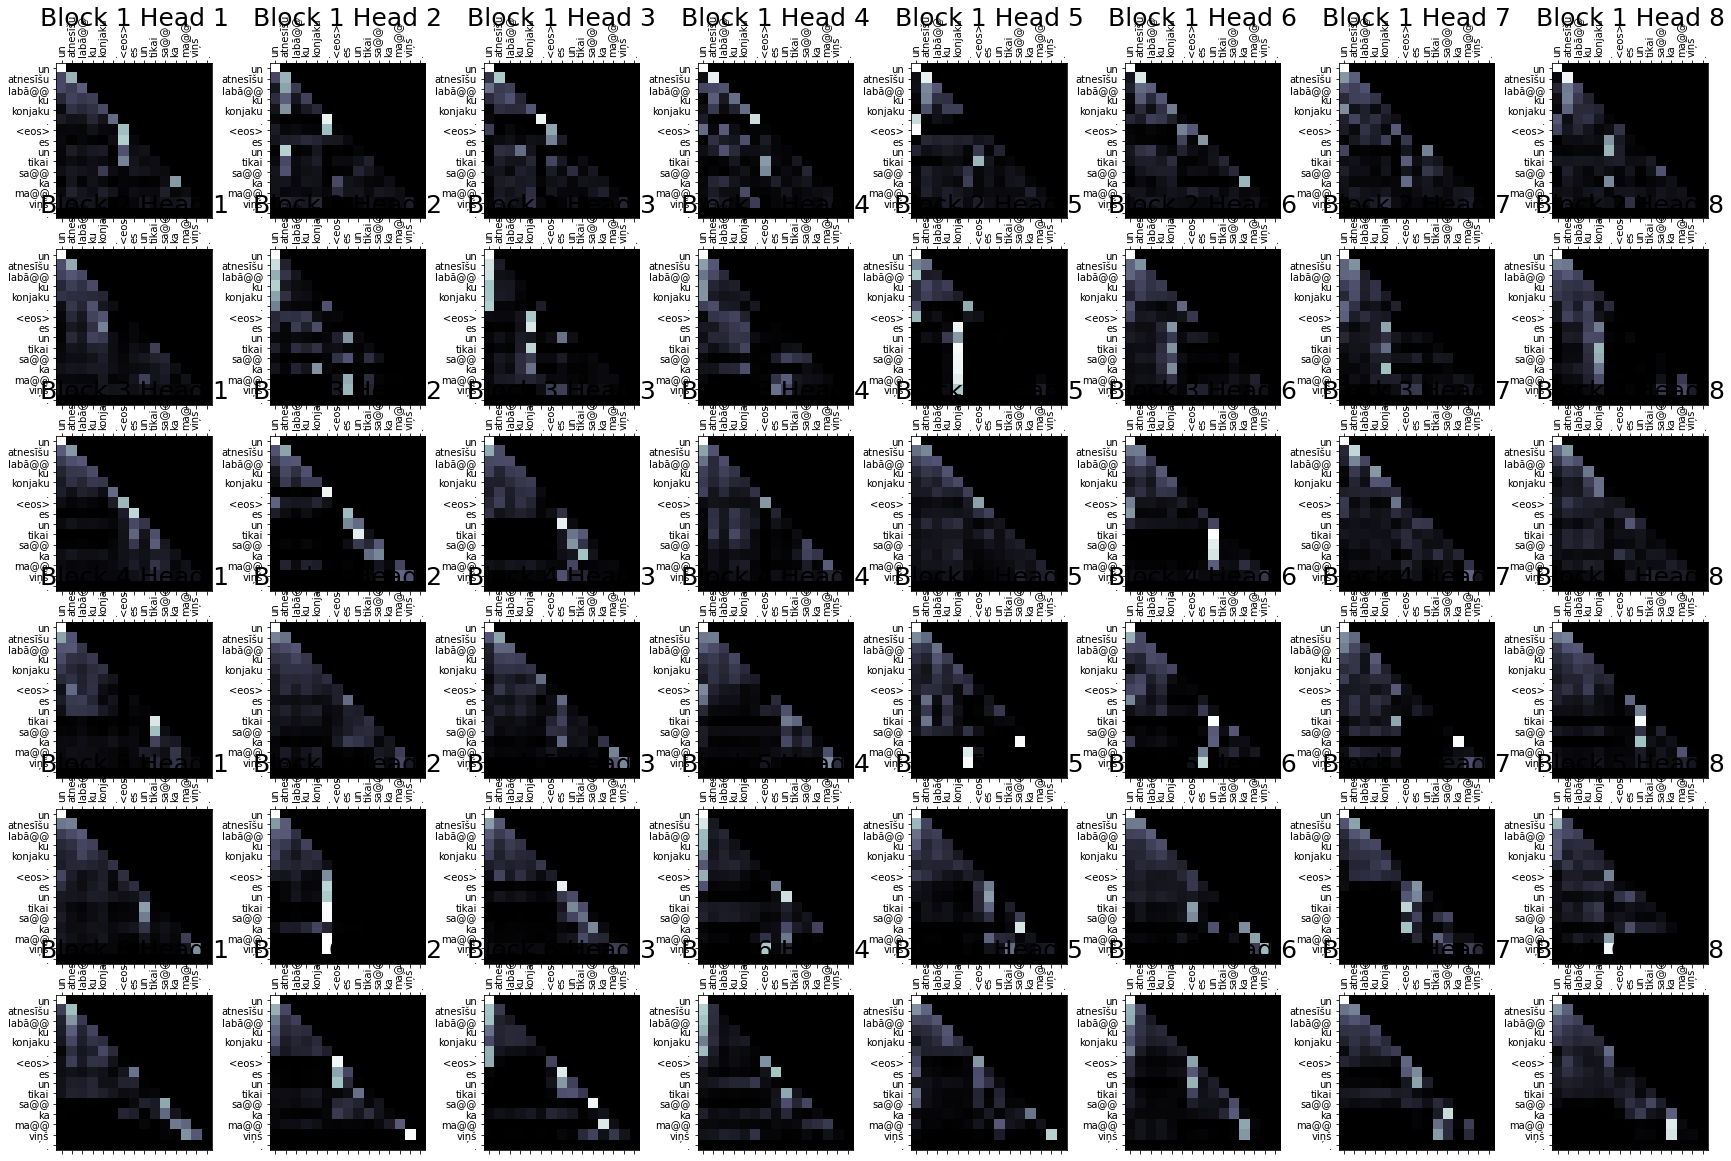

In [ ]:
fig, plots = plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))

axis_text = tokenizer_input.decode(encoded_input, True).split()

axis_text.append('<eos>')

axis_text += tokenizer_input.decode(predicted, True).split()

limit = len(axis_text)
for bi in range(number_of_layers):
    for hi in range(number_of_heads):
        attetion_plot = torch.zeros(limit, limit)
        for di in range(limit):
            attetion_plot[:di, :di] = attention_state[bi][di][0,hi,:di,:di].data

        ax = plots[bi][hi]
        ax.matshow(attetion_plot.numpy(), cmap='bone')

        # Set up axes
        ax.set_xticklabels([''] + axis_text, rotation=90)
        ax.set_yticklabels([''] + axis_text)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Set up a title
        ax.set_title(f'Block {bi + 1} Head {hi + 1}', size=25, pad=30)
        
plt.show()

In [ ]:
# In case the previous cell is not plotting anything, uncomment the code below and execute. After that, the plotting should be fine.
# %matplotlib inline
# import numpy as np
# x = np.linspace(0, 10, 100)

# fig = plt.figure()
# plt.plot(x, np.sin(x), '-')
# plt.plot(x, np.cos(x), '--');

#Calculate BLEU

In [86]:
def clean_tokens(sentence):
    return sentence.replace('@@ ', '').replace(' @', '').replace('@ ', '')

In [87]:
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# smooth = SmoothingFunction().method7

translation_results = []
eval_text = []
bleu_results = []
for idx, context in enumerate(valid_input):
    encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
    x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
    y = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10)[0]

    intent = len(encoded_input) + 1
    predicted = y[intent:]
    completion = clean_tokens(tokenizer_output.decode(predicted, True))
    translation_results.append(completion)

    eval = clean_tokens(valid_output[idx])
    eval_text.append(eval)
    # bleu = sentence_bleu([eval], completion, smoothing_function=smooth)
    # bleu_results.append(bleu)

# print(f"Averare BLEU: {np.mean(bleu_results)}")

In [88]:
with open('hemingway_valid.out', 'w') as f:
    f.write("\n".join(translation_results))

with open('hemingway_valid.ref', 'w') as f:
    f.write("\n".join(eval_text))

In [89]:
!perl mosesdecoder/scripts/generic/multi-bleu.perl hemingway_valid.ref < hemingway_valid.out

BLEU = 9.61, 43.4/14.8/6.2/3.3 (BP=0.896, ratio=0.901, hyp_len=4675, ref_len=5188)
It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.


In [90]:
!cat hemingway_valid.out | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > hemingway_valid.detok.out
!cat hemingway_valid.ref | mosesdecoder/scripts/tokenizer/detokenizer.perl -l lv > hemingway_valid.detok.ref

Detokenizer Version $Revision: 4134 $
Language: lv
Detokenizer Version $Revision: 4134 $
Language: lv


In [91]:
#!pip install sacrebleu
!pip show sacrebleu

Name: sacrebleu
Version: 1.5.1
Summary: Hassle-free computation of shareable, comparable, and reproducible BLEU, chrF, and TER scores
Home-page: https://github.com/mjpost/sacrebleu
Author: Matt Post
Author-email: post@cs.jhu.edu
License: Apache License 2.0
Location: /home/guntis/anaconda3/envs/tw131/lib/python3.8/site-packages
Requires: portalocker
Required-by: 


In [92]:
import sacrebleu

with open('hemingway_valid.detok.ref', 'r') as f:
    eval_ref = [l.strip() for l in f.readlines()]
with open('hemingway_valid.detok.out', 'r') as f:
    translation_results = [l.strip() for l in f.readlines()]

refs = [eval_ref]
sys = translation_results
bleu = sacrebleu.corpus_bleu(sys, refs)
print(bleu.score)

9.617007660325706


#Interactive translator

In [52]:
context = input("Enter your English text to translate: ")

# Predict Latvian output
encoded_input = tokenizer_input.encode(tokenizer_input.tokenize(context, block_size))
x = torch.tensor(encoded_input, dtype=torch.long)[None,...].to(trainer.device)
y, attention_state = sample(model, x, block_size, temperature=1.0, sample=False, top_k=10, output_attention=True)

intent = len(encoded_input) + 1

predicted = y[0][intent:]
completion = tokenizer_output.decode(predicted, True)
print(f'Input:            {context}')
print(f'Predicted output: {completion}')


# Plot attention
fig, plots = plt.subplots(nrows=number_of_layers, ncols=number_of_heads, figsize=(30, 20))

axis_text = tokenizer_input.decode(encoded_input, True).split()

axis_text.append('<eos>')

axis_text += tokenizer_input.decode(predicted, True).split()

limit = len(axis_text)
for bi in range(number_of_layers):
    for hi in range(number_of_heads):
        attetion_plot = torch.zeros(limit, limit)
        for di in range(limit):
            attetion_plot[:di, :di] = attention_state[bi][di][0,hi,:di,:di].data

        ax = plots[bi][hi]
        ax.matshow(attetion_plot.numpy(), cmap='bone')

        # Set up axes
        ax.set_xticklabels([''] + axis_text, rotation=90)
        ax.set_yticklabels([''] + axis_text)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # Set up a title
        ax.set_title(f'Block {bi + 1} Head {hi + 1}', size=25, pad=30)
        
plt.show()

Enter your English text to translate: "What do you mean?", he asked.
Input:            "What do you mean?", he asked.
Predicted output: the orderly . &quot; 


<ipython-input-52-362679eb645d>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + axis_text, rotation=90)
<ipython-input-52-362679eb645d>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + axis_text)
<ipython-input-52-362679eb645d>:46: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
